# Импортируем библиотеки

In [1]:
import pandas as pd
import re

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#mean_absolute_percentage_error нет в sklearn v0.22, поэтому напишем сами:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / (y_true)))

from sklearn.metrics import mean_squared_error , max_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler, power_transform
from sklearn.model_selection import train_test_split

from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, StackingRegressor

import xgboost as xgb
import optuna
import lightgbm as lgbm

np.random.seed(42)

# Предобработка данных

In [2]:
df = pd.read_csv('data.csv')

In [3]:
df.head()

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
0,Active,NaN,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,NaN,611019,"$418,000"
1,for sale,NaN,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,NaN,201916904,"$310,000"
2,for sale,NaN,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,NaN,yes,FR19221027,"$2,895,000"
3,for sale,NaN,single-family home,4311 Livingston Ave,8 Baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,5 Beds,TX,3.0,NaN,NaN,14191809,"$2,395,000"
4,for sale,NaN,lot/land,1524 Kiscoe St,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,32908,NaN,FL,NaN,NaN,NaN,861745,"$5,000"


In [4]:
df.shape

(377185, 18)

Количество пропущенных значенний:

In [5]:
df.isna().sum() / (df.shape[0])*100 #процент пропусков

status          10.583136
private pool    98.891525
propertyType     9.208479
street           0.000530
baths           28.192532
homeFacts        0.000000
fireplace       72.661956
city             0.009014
schools          0.000000
sqft            10.757851
zipcode          0.000000
beds            24.200856
state            0.000000
stories         39.957846
mls-id          93.387330
PrivatePool     89.312672
MlsId           17.731352
target           0.657767
dtype: float64

Удаляем строки без целевой переменной:

In [6]:
df = df.loc[df['target'].isna() == False]

In [7]:
df.shape

(374704, 18)

Очищаем целевую переменную:

In [8]:
def target_format(target):
    target = re.sub('[^0-9]', '', target) #оставляем только цифры
    target = int(target)
    return target

In [9]:
df['target'] = df['target'].apply(target_format)
df['target'].describe()

count    3.747040e+05
mean     6.447575e+05
std      1.841431e+06
min      1.000000e+00
25%      1.869900e+05
50%      3.200000e+05
75%      5.821000e+05
max      1.950000e+08
Name: target, dtype: float64

Очищаем признаки:

In [10]:
# Преобразовываем в действительные числа
def features_float_format(feature):
    if feature == 0:
        return feature
    feature = re.sub('1 1/2', '1.5', str(feature)) # заменяем 1 1/2 на 1.5 (признак stories)
    feature = re.sub('[^0-9,\.]', '', feature) # оставляем только цифры
    feature = re.sub(',', '.', feature) # заменяем ',' на '.'
    
    try:
        feature = float(feature)
    #если feature - пустая строка, возвращаем 0
    except:
        feature = 0
    return feature
# Преобразовываем площадь
def sqft_format(feature):
    if feature == 0:
        return feature
    feature = re.sub('[^0-9\.]', '', feature) # оставляем только цифры
   
    try:
        feature = float(feature)
    #если feature - пустая строка, возвращаем 0
    except:
        feature = 0
    return feature
# Преобразовываем статус
def status_format(status):
    status = status.lower()
    # если дом ещё не сделан,оставляем только 'coming soon', дату удаляем
    if status.startswith('coming soon'): 
        status = 'coming soon'
        
    status = re.sub('[^a-z]', ' ', status) # оставляем только буквы
    status = re.sub(r'\b\w{,2}\b', '', status) # удаляем сочетание из 1 и 2 букв
    status = re.sub(r'\s+', '', status) # заменяем 1 или более пробелов на ''
    if status == 'active' or status == 'for sale': # бóльшая часть домов - for sale или active
        status = 1
    else:
        status = 0
    return status
#Преобразовываем фичу камина
def fireplace_format(fireplace):
    if fireplace == 0:
        return fireplace
    fireplace = fireplace.lower()
    
    if fireplace.count('no')>0:
        fireplace = 0
    else:
        fireplace = 1
    return fireplace

In [11]:
dummy_features = ['status','state']  
drop_features = ['street', 'mls-id', 'MlsId', 'schools', 'homeFacts', 'city', 'zipcode'] 

#### Status

In [12]:
df.status.value_counts()

for sale                     156100
Active                       105206
For sale                      43465
foreclosure                    5677
New construction               5459
                              ...  
Coming soon: Nov 8.               1
Coming soon: Dec 27.              1
Pending Take Backups              1
Coming soon: Dec 1.               1
Pending, Continue to Show         1
Name: status, Length: 156, dtype: int64

Приблизительно 80% домов - ```Active``` или ```for sale```, поэтому вместо них ставим ```1```, иначе ```0```
(заполняем пропуски на пустые строки, и применяем ```status_format```):

In [13]:
df['status'] = df['status'].fillna('')
df['status'] = df['status'].apply(status_format)

#### Property Type

In [14]:
df.propertyType.value_counts()

single-family home                                                   91376
Single Family                                                        61888
Single Family Home                                                   31725
condo                                                                25878
lot/land                                                             20532
                                                                     ...  
Attached, Attached Duplex, End Unit, Ranch, Side by Side                 1
1 Story, Contemporary, Traditional, Mediterranean                        1
Cluster Home, Penthouse                                                  1
Cape Cod, Victorian/Federal                                              1
Single Detached, Early American, Other (See Remarks), Traditional        1
Name: propertyType, Length: 1279, dtype: int64

Приблизительно 50% домов - ```single family```, поэтому оставляем только этот признак:

In [15]:
def propertyType_format(propertyType):
    propertyType = propertyType.lower()
    propertyType = re.sub('[^a-z]', ' ', propertyType)# оставляем только буквы
    
    # если начинается на 'single family' - ставим 1, иначе 0
    if propertyType.startswith('single family'): 
        propertyType = 1 
    else:
        propertyType = 0
    return propertyType

In [16]:
df['propertyType'] = df['propertyType'].fillna('')
df['propertyType'] = df['propertyType'].apply(propertyType_format)

#### Private pool
Вместо пропусков ставим ```no```, заполняем вместо ```yes``` - 1, вместо ```no``` - 0

In [17]:
df['private pool'] = df['private pool'].fillna('no')
df['private pool'] = df['private pool'].apply(lambda pool: 1 if pool.lower() == 'yes' else 0)

df['PrivatePool'] = df['PrivatePool'].fillna('no')
df['PrivatePool'] = df['PrivatePool'].apply(lambda pool: 1 if pool.lower() == 'yes' else 0)

df['PrivatePool'] = df['private pool'] | df['PrivatePool']
df.drop(['private pool'], axis = 1, inplace = True)

#### Baths, sqft, beds, stories, fireplace
Заполняем пропуски нулями (кроме этажей - их заменяем на ```1```).
К ```Baths, beds, stories``` применяем ```features_float_format```, к ```sqft - sqft_format```, а к ```fireplace``` - ```fireplace_format```:

In [18]:
df['baths'] = df['baths'].fillna(0)
df['baths'] = df['baths'].apply(features_float_format)

df['sqft'] = df['sqft'].fillna(0)
df['sqft'] = df['sqft'].apply(sqft_format)

df['beds'] = df['beds'].fillna(0)
df['beds'] = df['beds'].apply(features_float_format)

df['stories'] = df['stories'].fillna(1)
df['stories'] = df['stories'].apply(features_float_format)

df['fireplace'] = df['fireplace'].fillna(0)
df['fireplace'] = df['fireplace'].apply(fireplace_format)

#### Year Built

In [19]:
df['homeFacts'] = df['homeFacts'].apply(eval) # конвертируем строку в словарь, используя eval

Нужное нам значение хранится в первом словаре, который хранится в списке, который, в свою очередь, хранится в словаре с ключом ```atAGlanceFacts```:

In [20]:
M = df['homeFacts'][0]
print(M,'\n')
print(M['atAGlanceFacts'],'\n')
print(M['atAGlanceFacts'][0],'\n')
print(M['atAGlanceFacts'][0]['factValue'])

{'atAGlanceFacts': [{'factValue': '2019', 'factLabel': 'Year built'}, {'factValue': '', 'factLabel': 'Remodeled year'}, {'factValue': 'Central A/C, Heat Pump', 'factLabel': 'Heating'}, {'factValue': '', 'factLabel': 'Cooling'}, {'factValue': '', 'factLabel': 'Parking'}, {'factValue': None, 'factLabel': 'lotsize'}, {'factValue': '$144', 'factLabel': 'Price/sqft'}]} 

[{'factValue': '2019', 'factLabel': 'Year built'}, {'factValue': '', 'factLabel': 'Remodeled year'}, {'factValue': 'Central A/C, Heat Pump', 'factLabel': 'Heating'}, {'factValue': '', 'factLabel': 'Cooling'}, {'factValue': '', 'factLabel': 'Parking'}, {'factValue': None, 'factLabel': 'lotsize'}, {'factValue': '$144', 'factLabel': 'Price/sqft'}] 

{'factValue': '2019', 'factLabel': 'Year built'} 

2019


In [21]:
def yearBuilt_format(homeFacts):
    # если homeFacts - непустой словарь, берём значение 'atAGlanceFacts', иначе 0
    homeFacts = homeFacts.get('atAGlanceFacts', 0) 
    if homeFacts == 0: 
        return 0
    # берём первый елемент списка
    yearBuilt = homeFacts[0]
    # если словарь не пуст, то берем значение
    if yearBuilt.get('factLabel') == 'Year built':
        yearBuilt = yearBuilt.get('factValue')
    # берём первый второй списка
    yearRemodeled = homeFacts[1]
    # если словарь не пуст, то берем значение
    if yearRemodeled.get('factLabel') == 'Remodeled year':
        yearRemodeled = yearRemodeled.get('factValue')
    
    # если yearRemodeled - число, выводим его, иначе - yearBuilt
    try:
        yearRemodeled = int(yearRemodeled)
        return yearRemodeled
    except:
        yearRemodeled = 0
    # если homeFacts - число, то выводим его, иначе 0
    try:
        yearBuilt = int(yearBuilt)
    except:
        yearBuilt = 0
    return yearBuilt

In [22]:
df['yearBuilt'] = df['homeFacts'].apply(yearBuilt_format)

#### Heating

In [23]:
def heating_format(homeFacts):
    # если homeFacts - непустой словарь, берём значение 'atAGlanceFacts', иначе 0
    homeFacts = homeFacts.get('atAGlanceFacts', 0) 
    if homeFacts == 0: 
        return 0
    # берём третий елемент списка
    homeFacts = homeFacts[2]
    # если словарь не пуст, то берем значение
    if homeFacts.get('factLabel') == 'Heating':
        homeFacts = homeFacts.get('factValue')
        
    if homeFacts in ['','none','no data']: # если homeFacts '','none' или 'no data' - считаем, что в доме нет отопления
        return 0
    else:
        return 1

In [24]:
df['heating'] = df['homeFacts'].apply(heating_format)

#### Parking

In [25]:
def parking_format(homeFacts):
    # если homeFacts - непустой словарь, берём значение 'atAGlanceFacts', иначе 0
    homeFacts = homeFacts.get('atAGlanceFacts', 0) 
    if homeFacts == 0: 
        return 0
    # берём пятый елемент списка
    homeFacts = homeFacts[4]
    # если словарь не пуст, то берем значение
    if homeFacts.get('factLabel') == 'Parking':
        homeFacts = homeFacts.get('factValue')
        homeFacts = str(homeFacts).lower()
        
    if homeFacts in ['','none','no data']: # если homeFacts '','none' или 'no data' - считаем, что участке нет парковки
        homeFacts = 0
    else:
        homeFacts = re.sub('[^0-9]', '', homeFacts) # оставляем только цифры
        try:
            homeFacts = int(homeFacts)
            
        # Если homeFacts - строка ('Attached Garage'), считаем, что в доме 1 парковка
        except:
            homeFacts = 1
    return homeFacts

In [26]:
df['parking'] = df['homeFacts'].apply(parking_format)

#### Lot size

In [27]:
def lotsize_format(homeFacts):
    # если homeFacts - непустой словарь, берём значение 'atAGlanceFacts', иначе 0
    homeFacts = homeFacts.get('atAGlanceFacts', 0) 
    if homeFacts == 0: 
        return 0
    # берём шестой елемент списка
    homeFacts = homeFacts[5]
    # если словарь не пуст, то берем значение
    if homeFacts.get('factLabel') == 'lotsize':
        homeFacts = str(homeFacts.get('factValue'))
        
    if homeFacts == 0:
        return homeFacts
    homeFacts = homeFacts.replace('Sq. Ft.','')
    homeFacts = re.sub('[^0-9\.]', '', homeFacts) # оставляем только цифры
   
    try:
        homeFacts = float(homeFacts)
    #если homeFacts - пустая строка, возвращаем 0
    except:
        homeFacts = 0
    if homeFacts < 10: # если homeFacts подано в акрах
        homeFacts *= 43560
    return homeFacts

Если lotsize равно 0, то записываем в lotsize значенние в sqft:

In [28]:
df['lotsize'] = df.apply(lambda x: x['sqft'] if lotsize_format(x['homeFacts']) == 0 
                         else lotsize_format(x['homeFacts']), 
                         axis = 1)

#### Schools rating

In [29]:
df['schools'] = df['schools'].apply(eval) # конвертируем строку в словарь, используя eval

Список с рейтингами школ хранится в словаре, который хранится в списке:

In [30]:
M = df['schools'][0]
print(M,'\n')
print(M[0],'\n')
print(M[0]['rating'])

[{'rating': ['4', '4', '7', 'NR', '4', '7', 'NR', 'NR'], 'data': {'Distance': ['2.7 mi', '3.6 mi', '5.1 mi', '4.0 mi', '10.5 mi', '12.6 mi', '2.7 mi', '3.1 mi'], 'Grades': ['3–5', '6–8', '9–12', 'PK–2', '6–8', '9–12', 'PK–5', 'K–12']}, 'name': ['Southern Pines Elementary School', 'Southern Middle School', 'Pinecrest High School', 'Southern Pines Primary School', "Crain's Creek Middle School", 'Union Pines High School', 'Episcopal Day Private School', 'Calvary Christian Private School']}] 

{'rating': ['4', '4', '7', 'NR', '4', '7', 'NR', 'NR'], 'data': {'Distance': ['2.7 mi', '3.6 mi', '5.1 mi', '4.0 mi', '10.5 mi', '12.6 mi', '2.7 mi', '3.1 mi'], 'Grades': ['3–5', '6–8', '9–12', 'PK–2', '6–8', '9–12', 'PK–5', 'K–12']}, 'name': ['Southern Pines Elementary School', 'Southern Middle School', 'Pinecrest High School', 'Southern Pines Primary School', "Crain's Creek Middle School", 'Union Pines High School', 'Episcopal Day Private School', 'Calvary Christian Private School']} 

['4', '4', '

In [31]:
def rating_format(schools):
    # если schools - непустой словарь, берём значение 'rating', иначе 0
    schools = schools[0]
    schools = schools.get('rating', 0)
    if schools == 0: 
        return 0
    
    rating = []
    for x in schools:
        x = re.sub('/10','',x) # если рейтинг записан в формате 'x/10', заменяем на 'x'
        rating.append(features_float_format(x)) # с помощью features_float_format превращаем x в число
    # ищем среднее арифметическое рейтингов
    return np.mean(rating)

Применяем ```rating_format```, если результат - ```nan```, заменяем на ```0```:

In [32]:
df['rating'] = df['schools'].apply(rating_format)
df['rating'] = df['rating'].fillna(0)

C:\Users\andru\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning:

Mean of empty slice.



#### Distance
По аналогии с ```rating```, выбираем значение из списка словарей и ищем среднее арифметическое расстояний

In [33]:
def distance_format(schools):
    # если schools - непустой словарь, берём значение 'data', иначе 0
    schools = schools[0]
    schools = schools.get('data', 0)
    if schools == 0: 
        return 0
    # если schools - непустой словарь, берём значение 'distance', иначе 0
    schools = schools.get('Distance', 0)
    if schools == 0: 
        return 0
    
    distance=[]
    for x in schools:
        distance.append(features_float_format(x)) # с помощью features_float_format превращаем x в число
    # ищем среднее арифметическое расстояний
    return np.mean(distance)

Применяем ```distance_format``` и заполняем пропуски нулями:

In [34]:
df['distance'] = df['schools'].apply(distance_format)
df['distance'] = df['distance'].fillna(0)

Удаляем ненужные фичи:

In [35]:
df.drop(drop_features, axis = 1, inplace = True)

#### State 
Штаты - dummy-feature, поэтому применяем к ```df['state']``` функцию ```pd.get_dummies```, и конкатенируем результат к датасету:

In [36]:
df = pd.concat([df, pd.get_dummies(df['state'])], axis = 1)
df.drop('state', axis = 1, inplace = True)

##### Итог:
Мы предобработали и очистили данные, и получили 8 числовых и 43 dummy признака.

# Статистический анализ

In [37]:
df.head()

,status,propertyType,baths,fireplace,sqft,beds,stories,PrivatePool,target,yearBuilt,...,OT,PA,SC,TN,TX,UT,VA,VT,WA,WI
0,1,1,3.5,1,2900.0,4.0,1.0,0,418000,2019,...,0,0,0,0,0,0,0,0,0,0
1,0,1,3.0,0,1947.0,3.0,2.0,0,310000,2019,...,0,0,0,0,0,0,0,0,1,0
2,0,1,2.0,1,3000.0,3.0,1.0,1,2895000,1967,...,0,0,0,0,0,0,0,0,0,0
3,0,1,8.0,1,6457.0,5.0,3.0,0,2395000,2006,...,0,0,0,0,1,0,0,0,0,0
4,0,0,0.0,0,0.0,0.0,1.0,0,5000,0,...,0,0,0,0,0,0,0,0,0,0


In [38]:
df.describe(include = 'all')

,status,propertyType,baths,fireplace,sqft,beds,stories,PrivatePool,target,yearBuilt,...,OT,PA,SC,TN,TX,UT,VA,VT,WA,WI
count,374704.000000,374704.000000,3.747040e+05,374704.000000,3.747040e+05,374704.000000,374704.000000,374704.000000,3.747040e+05,3.747040e+05,...,374704.000000,374704.000000,374704.000000,374704.000000,374704.000000,374704.000000,374704.000000,374704.000000,374704.000000,374704.000000
mean,0.281953,0.493694,3.718902e+02,0.267360,5.921395e+03,2.417060,1.500874,0.118152,6.447575e+05,2.990631e+06,...,0.000003,0.014705,0.000075,0.048654,0.222464,0.003525,0.002135,0.002306,0.036666,0.001206
std,0.449951,0.499961,1.928389e+05,0.442583,1.499304e+06,3.936648,3.338053,0.322788,1.841431e+06,1.293752e+09,...,0.001634,0.120369,0.008644,0.215145,0.415901,0.059271,0.046157,0.047964,0.187941,0.034711
min,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,1.000000e+00,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000e+00,0.000000,1.035000e+03,0.000000,1.000000,0.000000,1.869900e+05,1.936000e+03,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,2.000000e+00,0.000000,1.656000e+03,3.000000,1.000000,0.000000,3.200000e+05,1.981000e+03,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,3.000000e+00,1.000000,2.458000e+03,4.000000,2.000000,0.000000,5.821000e+05,2.006000e+03,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.161161e+08,1.000000,7.959794e+08,871.000000,1120.000000,1.000000,1.950000e+08,5.599906e+11,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Построим матрицу корреляций:

In [39]:
corr = df.corr()

cmap = sns.diverging_palette(5, 250, as_cmap=True)

def magnify():
    return [dict(selector="th",
                 props=[("font-size", "5pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "8pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '8pt')])
]

corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("correlation matrix")\
    .set_precision(2)\
    .set_table_styles(magnify())

Избыточной кореляции между признаками нету, значит никаких признаков удалять ненужно. 
Построим гистограмы с различными признаками:

Построим гистограмму логарифма целевой переменной:

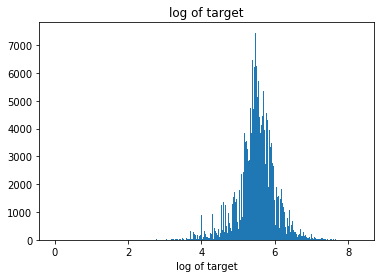

In [40]:
_ = plt.hist(np.log10(df['target']),bins = 'auto')
plt.title('log of target')
plt.xlabel('log of target')
plt.show()

Отсюда видно, что существует пик в точке 5.5, а распределение - похоже на нормальное.

Удалим объекты, где стоимость домов меньше ```1000$``` или больше ```100 000 000$```:

In [41]:
df = df.loc[(df['target']> 10**3.5) & (df['target'] < 10**7.5)]

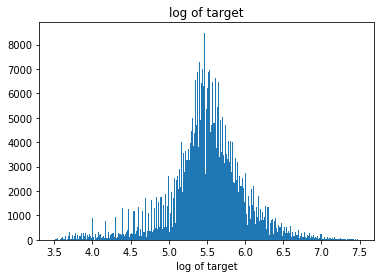

In [42]:
_ = plt.hist(np.log10(df['target']),bins = 'auto')
plt.title('log of target')
plt.xlabel('log of target')
plt.show()

Построим гистограмму логарифма площади, если площадь не равна ```0```:

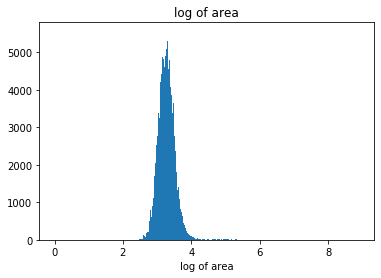

In [43]:
_ = plt.hist(np.log10(df.loc[(df['sqft']>0)]['sqft']),bins = 'auto')
plt.title('log of area')
plt.xlabel('log of area')
plt.show()

Удалим объекты, где площадь домов меньше ```300``` или больше ```10 000``` кв. фт:

In [44]:
df = df.loc[(df['sqft']> 300) & (df['sqft'] < 10**4)]

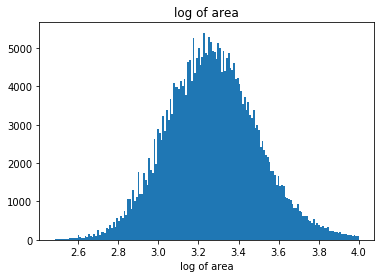

In [45]:
_ = plt.hist(np.log10(df['sqft']),bins = 'auto')
plt.title('log of area')
plt.xlabel('log of area')
plt.show()

Видно пик около 3.25. Значит, большинство значенний площади находятся на промежутке от около ```1000``` до ```10000```.

Построим гистограмму распределений кроватей:

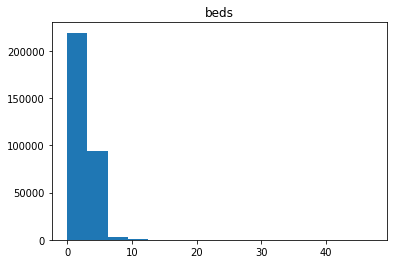

In [46]:
_ = plt.hist(df['beds'],bins = 15)
plt.title('beds')
plt.show()

Удалим объекты, где количество кроватей больше ```20```:

In [47]:
df = df.loc[(df['beds'] <= 20)]

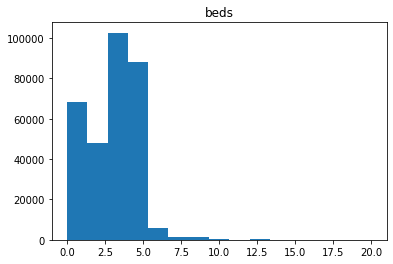

In [48]:
_ = plt.hist(df['beds'],bins = 15)
plt.title('beds')
plt.show()

Построим гистограмму распределений логарифма lot siz'а, убрав объекты, где lotsize равно ```0```:

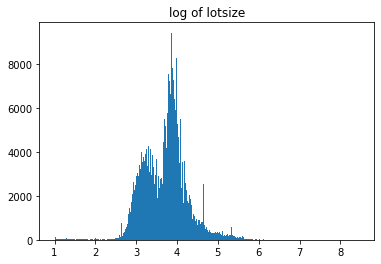

In [49]:
_ = plt.hist(np.log10(df[df['lotsize']>0]['lotsize']),bins = 'auto')
plt.title('log of lotsize')
plt.show()

Заменим значенния этажей больше ```100``` на ```2```:

In [50]:
df = df.where(df['stories']<100,2)

Построим гистограмму распределений рейтинга школ:

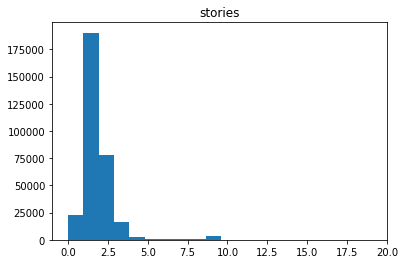

In [51]:
_ = plt.hist(df['stories'],bins = 100)
plt.title('stories')
plt.xlim(-1,20)
plt.show()

Построим гистограмму распределений рейтинга школ:

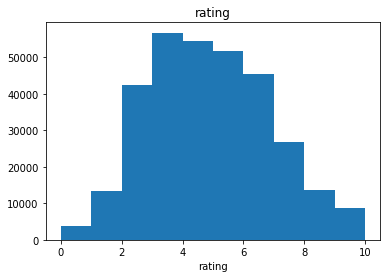

In [52]:
_ = plt.hist(df['rating'],bins = 10)
plt.title('rating')
plt.xlabel('rating')
plt.show()

Построим гистограмму логарифма расстояний:

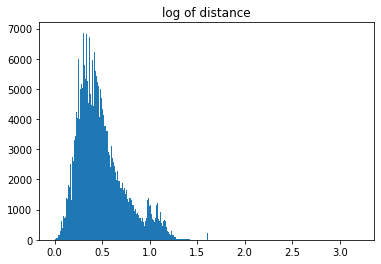

In [53]:
_ = plt.hist(np.log10(df['distance']+1),bins = 'auto')
plt.title('log of distance')
plt.show()

Заменим значенния ванных больше ```40``` на ```2```:

In [54]:
df = df.where(df['baths']<40,2)

Построим гистограмму распределений ванных, убрав объекты, где количество ванных больше 20 или равно 0:

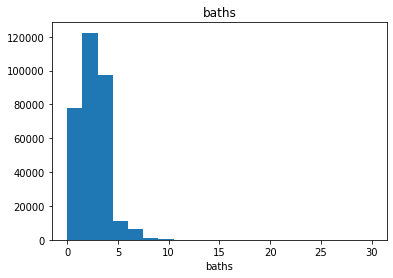

In [55]:
_ = plt.hist(df['baths'],bins = 20)
plt.title('baths')
plt.xlabel('baths')
plt.show()

Заменим значенния ```yearBuilt``` больше ```2021``` и меньше ```1900``` на ```2019```:

In [56]:
df = df.where((df['yearBuilt'] < 2021) & (df['yearBuilt'] > 1900),2019)

Построим гистограмму распределений года постройки, убрав значенния меньше 1875:

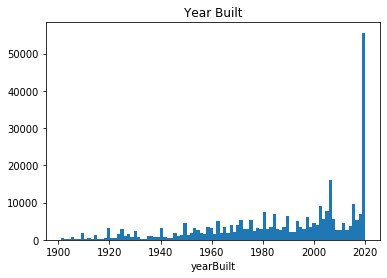

In [68]:
_ = plt.hist(df.loc[df['yearBuilt'] >= 1875]['yearBuilt'],bins = 'auto')
plt.title('Year Built')
plt.xlabel('yearBuilt')
plt.show()

###### Точечные диаграммы целевой переменной и признаков

Построим точечную диаграмму целевой переменной и рейтинга школ:

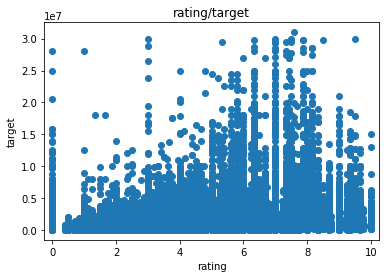

In [58]:
_ = plt.scatter(df['rating'],df['target'])

plt.xlim(-0.25,10.25)

plt.title('rating/target')
plt.xlabel('rating')
plt.ylabel('target')

plt.show()

Построим точечную диаграмму целевой переменной и логарифма расстояний до школ:

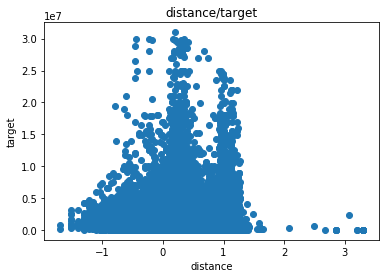

In [59]:
_ = plt.scatter(np.log10(df.loc[df['distance']>0]['distance']),df.loc[df['distance']>0]['target'])
# Ограничим график по осям, чтобы рассмотреть данные без шумов

plt.title('distance/target')
plt.xlabel('distance')
plt.ylabel('target')

plt.show()

Построим точечную диаграмму логарифма целевой переменной и логарифма количества этажей:

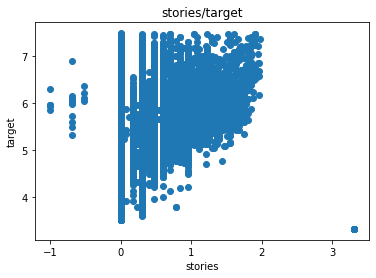

In [60]:
M = df.loc[(df['stories']>0) & (df['target']>0)] # фильтруем нулевые значения
_ = plt.scatter(np.log10(M['stories']),
                np.log10(M['target']))

plt.title('stories/target')
plt.xlabel('stories')
plt.ylabel('target')

plt.show()

Построим точечную диаграмму целевой переменной и количества кроватей:

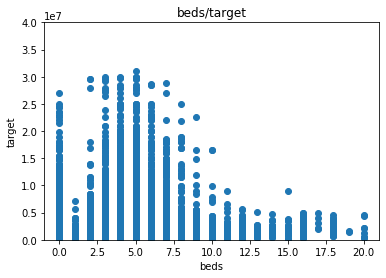

In [61]:
_ = plt.scatter(df['beds'],df['target'])
# Ограничим график по осям
plt.xlim(-1,21)
plt.ylim(-10,1e7*4)

plt.title('beds/target')
plt.xlabel('beds')
plt.ylabel('target')

plt.show()

Построим точечную диаграмму целевой переменной и года постройки:

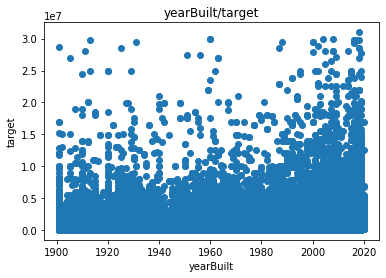

In [62]:
_ = plt.scatter(df['yearBuilt'],df['target'])

plt.title('yearBuilt/target')
plt.xlabel('yearBuilt')
plt.ylabel('target')

plt.show()

Построим точечную диаграмму логарифма целевой переменной и логарифма площади:

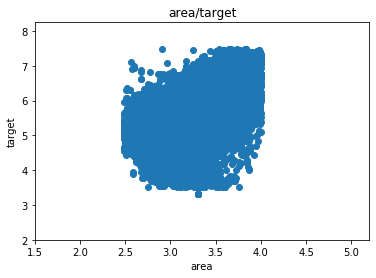

In [63]:
M = df.loc[(df['sqft']>0) & (df['target']>0)] # фильтруем нулевые значения
_ = plt.scatter(np.log10(M['sqft']),
                np.log10(M['target']))
# Ограничим график по осям, чтобы рассмотреть данные без шумов
plt.xlim(1.5,5.2)
plt.ylim(2,8.25)

plt.title('area/target')
plt.xlabel('area')
plt.ylabel('target')

plt.show()

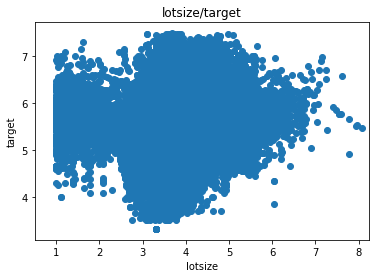

In [64]:
M = df.loc[(df['lotsize']>0) & (df['target']>0)] # фильтруем нулевые значения
_ = plt.scatter(np.log10(M['lotsize']),
                np.log10(M['target']))
# Ограничим график по осям, чтобы рассмотреть данные без шумов
plt.xlim(0.5,8.25)

plt.title('lotsize/target')
plt.xlabel('lotsize')
plt.ylabel('target')

plt.show()

Поскольку распределения логарифма целевой переменной, логарифма lotsiz'а, логарифма площади и логарифма расстояний до школ - похожы на нормальные, то можна к этим признакам применить логарифм:

In [65]:
df = df.loc[(df['sqft']>0) & (df['distance']>0)] # берём только значения больше 0 (log(0)=-inf)
df['sqft'] = df['sqft'].apply(lambda x: np.log10(x))
df['distance'] = df['distance'].apply(lambda x: np.log10(x))
df['lotsize'] = df['lotsize'].apply(lambda x: np.log10(x+1))

Для ```target``` воспользуемся ```TransformedTargetRegressor```

Разобьем датафрейм на 2: в одном отдельные домы (```'single home'```), в других - остальные(квартиры, кондоминиумы):

In [66]:
#df = df.loc[df['propertyType']==0]
#df = df.drop('propertyType',axis=1)
df_single = df.loc[df['propertyType'] == 1]  
df_condo = df.loc[df['propertyType'] == 0]
df_single = df_single.drop('propertyType',axis = 1)
df_condo = df_condo.drop('propertyType',axis = 1) 

# Построение моделей

Разобьем данные на обучающаю и тестовую выборки:

In [69]:
X_single, y_single = df_single.drop('target', axis = 1), df_single['target']
X_condo, y_condo = df_condo.drop('target', axis = 1), df_condo['target']

In [70]:
X_train_single, X_test_single, y_train_single, y_test_single = train_test_split(X_single, y_single, 
                                                                                test_size = 0.2, random_state = 42)

X_train_condo, X_test_condo, y_train_condo, y_test_condo = train_test_split(X_condo, y_condo,
                                                                            test_size = 0.2, random_state = 42)

In [71]:
X_train_single.shape, y_train_single.shape, X_test_single.shape, y_test_single.shape

((130885, 52), (130885,), (32722, 52), (32722,))

In [72]:
X_train_condo.shape, y_train_condo.shape, X_test_condo.shape, y_test_condo.shape

((102197, 52), (102197,), (25550, 52), (25550,))

Списки с моделями для финального стекинга:

In [73]:
estimators_single = []
estimators_condo = []

Сделаем функцию для оценки точности предсказаний:

In [79]:
def evaluate(clf, X_train, y_train, X_test, y_test):
    #делаем предсказание
    train_predict = clf.predict(X_train)
    test_predict = clf.predict(X_test)
    #mse
    print('train mse :', mean_squared_error(y_train, train_predict) )
    print('test mse  :', mean_squared_error(y_test, test_predict) ,'\n')
    #max error
    print('train max error :', max_error(y_train, train_predict) )
    print('test max error  :', max_error(y_test, test_predict) ,'\n')
    #MAE
    print('train mean absolute error :', mean_absolute_error(y_train, train_predict) )
    print('test mean absolute error  :', mean_absolute_error(y_test, test_predict) ,'\n')
    #MAPE
    print('train mean absolute percentage error :', mean_absolute_percentage_error(y_train, train_predict) )
    print('test mean absolute percentage error  :', mean_absolute_percentage_error(y_test, test_predict) ,'\n')
    #RMSE
    print('train rmse :', np.sqrt(mean_squared_error(y_train, train_predict) ))
    print('test rmse  :',np.sqrt(mean_squared_error(y_test, test_predict) ),'\n')
    #Coefficient of determination
    print('train R^2', clf.score(X_train,y_train)) 
    print('test R^2', clf.score(X_test,y_test))

### Линейная регрессия

In [75]:
lr = LinearRegression()
# Применяем логарифм к целевой переменной
regr = TransformedTargetRegressor(regressor = lr, func=np.log, inverse_func=np.exp) 
regr.fit(X_train_single, y_train_single)

TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=LinearRegression())

In [80]:
evaluate(regr, X_train_single, y_train_single, X_test_single, y_test_single) 

train mse : 487661197194.3559
test mse  : 449755228019.6829 

train max error : 24736717.1174117
test max error  : 28137389.275095817 

train mean absolute error : 259660.20790887586
test mean absolute error  : 256091.42998945757 

train mean absolute percentage error : 0.605262987682672
test mean absolute percentage error  : 0.6396946148549697 

train rmse : 698327.4283560369
test rmse  : 670637.9261715541 

train R^2 0.45099893492029164
test R^2 0.450601931573133


In [81]:
lr = LinearRegression()
# Применяем логарифм к целевой переменной
regr = TransformedTargetRegressor(regressor = lr, func=np.log, inverse_func=np.exp) 

regr.fit(X_train_condo, y_train_condo)

TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=LinearRegression())

In [82]:
evaluate(regr, X_train_condo, y_train_condo, X_test_condo, y_test_condo)

train mse : 974470841314.047
test mse  : 972049125178.5237 

train max error : 35855720.1945932
test max error  : 30163625.167415485 

train mean absolute error : 312017.2955808485
test mean absolute error  : 313774.55164574925 

train mean absolute percentage error : 0.6762732501715262
test mean absolute percentage error  : 0.6918465844860948 

train rmse : 987152.8966244526
test rmse  : 985925.5170541656 

train R^2 0.3753593761874138
test R^2 0.3604892181469541


Попробуем различные деревья решений:

### Деревья решений

С помощью ```optune``` переберём различные варианты ```max_depth```:

In [89]:
def objective(trial):
    tree_max_depth = trial.suggest_int('tree_max_depth', 4, 11)
    
    tree_single = DecisionTreeRegressor(max_depth  = tree_max_depth, random_state = 42)
    
    regr = TransformedTargetRegressor(regressor = tree_single, func=np.log, inverse_func=np.exp)
    regr.fit(X_train_single, y_train_single)

    test_predict = regr.predict(X_test_single)

    return mean_squared_error(y_test_single, test_predict)

study = optuna.create_study(direction = 'minimize')
study.optimize(objective, n_trials = 8)

[I 2020-10-17 19:22:05,467] A new study created in memory with name: no-name-97a7720a-4baa-4790-ab3e-37a459349199
[I 2020-10-17 19:22:06,014] Trial 0 finished with value: 454874683799.13074 and parameters: {'tree_max_depth': 5}. Best is trial 0 with value: 454874683799.13074.
[I 2020-10-17 19:22:06,932] Trial 1 finished with value: 371795465288.2431 and parameters: {'tree_max_depth': 8}. Best is trial 1 with value: 371795465288.2431.
[I 2020-10-17 19:22:07,954] Trial 2 finished with value: 366824907852.12085 and parameters: {'tree_max_depth': 10}. Best is trial 2 with value: 366824907852.12085.
[I 2020-10-17 19:22:08,980] Trial 3 finished with value: 370497770695.7462 and parameters: {'tree_max_depth': 9}. Best is trial 2 with value: 366824907852.12085.
[I 2020-10-17 19:22:09,705] Trial 4 finished with value: 401725557664.0989 and parameters: {'tree_max_depth': 7}. Best is trial 2 with value: 366824907852.12085.
[I 2020-10-17 19:22:10,735] Trial 5 finished with value: 366824907852.1208

Итог: при максимальной глубине меньше 10 модель недообучается, а при максимальной глубине больше 10 - переобучается. 

In [85]:
tree_single = DecisionTreeRegressor(max_depth  = 10 ,random_state = 42)
regr = TransformedTargetRegressor(regressor = tree_single, func=np.log, inverse_func=np.exp)

regr.fit(X_train_single, y_train_single)

TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=DecisionTreeRegressor(max_depth=10,
                                                           random_state=42))

In [86]:
evaluate(regr, X_train_single, y_train_single, X_test_single, y_test_single)

train mse : 278443112435.58356
test mse  : 366824907852.12085 

train max error : 23401121.318864487
test max error  : 21836861.298858114 

train mean absolute error : 197141.9566085601
test mean absolute error  : 211946.17275660613 

train mean absolute percentage error : 0.42318349949620543
test mean absolute percentage error  : 0.4978613772382709 

train rmse : 527677.0910657232
test rmse  : 605660.7200835472 

train R^2 0.6865332608566758
test R^2 0.551905384819676


In [90]:
def objective(trial):
    tree_max_depth = trial.suggest_int('tree_max_depth', 4, 11)
    
    tree_condo = DecisionTreeRegressor(max_depth  = tree_max_depth, random_state = 42)
    
    regr = TransformedTargetRegressor(regressor = tree_condo, func=np.log, inverse_func=np.exp)
    regr.fit(X_train_condo, y_train_condo)

    test_predict = regr.predict(X_test_condo)

    return mean_squared_error(y_test_condo, test_predict)

study = optuna.create_study(direction = 'minimize')
study.optimize(objective, n_trials = 8)

[I 2020-10-17 19:22:25,163] A new study created in memory with name: no-name-a90bf3df-0f54-4ca2-9a1d-18275af58a3a
[I 2020-10-17 19:22:25,960] Trial 0 finished with value: 649450934328.68 and parameters: {'tree_max_depth': 11}. Best is trial 0 with value: 649450934328.68.
[I 2020-10-17 19:22:26,703] Trial 1 finished with value: 624141600184.0293 and parameters: {'tree_max_depth': 10}. Best is trial 1 with value: 624141600184.0293.
[I 2020-10-17 19:22:27,423] Trial 2 finished with value: 624141600184.0293 and parameters: {'tree_max_depth': 10}. Best is trial 1 with value: 624141600184.0293.
[I 2020-10-17 19:22:27,918] Trial 3 finished with value: 902142588941.6809 and parameters: {'tree_max_depth': 6}. Best is trial 1 with value: 624141600184.0293.
[I 2020-10-17 19:22:28,455] Trial 4 finished with value: 902142588941.6809 and parameters: {'tree_max_depth': 6}. Best is trial 1 with value: 624141600184.0293.
[I 2020-10-17 19:22:29,003] Trial 5 finished with value: 841907531319.3121 and par

In [91]:
tree_condo = DecisionTreeRegressor(max_depth  = 10 ,random_state = 42)
regr = TransformedTargetRegressor(regressor = tree_condo, func=np.log, inverse_func=np.exp)

regr.fit(X_train_condo, y_train_condo)

TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=DecisionTreeRegressor(max_depth=10,
                                                           random_state=42))

In [92]:
evaluate(regr, X_train_condo, y_train_condo, X_test_condo, y_test_condo)

train mse : 470878266163.8445
test mse  : 624141600184.0293 

train max error : 26064842.828544993
test max error  : 25810970.627504613 

train mean absolute error : 246516.3017516993
test mean absolute error  : 271883.7118064276 

train mean absolute percentage error : 0.5681430656653707
test mean absolute percentage error  : 0.6233888404005158 

train rmse : 686205.7025148104
test rmse  : 790026.3287916607 

train R^2 0.6981647049389933
test R^2 0.5893774580092401


### Попробуем различные ансамбли:

#### Bagging

С помощью ```optune``` переберём различные варианты ```n_estimators```:

In [93]:
def objective(trial):
    bagging_n_estimators = trial.suggest_int("bg_n_estimators", 5, 19)
    
    bagging_trees = BaggingRegressor(tree_single, n_estimators = bagging_n_estimators, random_state = 42)
    
    regr = TransformedTargetRegressor(regressor = bagging_trees, func=np.log, inverse_func=np.exp)
    regr.fit(X_train_single, y_train_single)

    test_predict = regr.predict(X_test_single)

    return mean_squared_error(y_test_single, test_predict)

study = optuna.create_study(direction = "minimize")
study.optimize(objective, n_trials = 7)

[I 2020-10-17 19:22:59,970] A new study created in memory with name: no-name-286a594d-c303-466e-bba2-7c1cf190cb3c
[I 2020-10-17 19:23:13,361] Trial 0 finished with value: 334365430357.43176 and parameters: {'bg_n_estimators': 19}. Best is trial 0 with value: 334365430357.43176.
[I 2020-10-17 19:23:26,153] Trial 1 finished with value: 335819962002.4809 and parameters: {'bg_n_estimators': 14}. Best is trial 0 with value: 334365430357.43176.
[I 2020-10-17 19:23:38,078] Trial 2 finished with value: 334967976736.5332 and parameters: {'bg_n_estimators': 16}. Best is trial 0 with value: 334365430357.43176.
[I 2020-10-17 19:23:48,297] Trial 3 finished with value: 336923379282.0072 and parameters: {'bg_n_estimators': 13}. Best is trial 0 with value: 334365430357.43176.
[I 2020-10-17 19:24:00,233] Trial 4 finished with value: 335612051679.9463 and parameters: {'bg_n_estimators': 15}. Best is trial 0 with value: 334365430357.43176.
[I 2020-10-17 19:24:06,889] Trial 5 finished with value: 33422761

In [94]:
bagging_trees = BaggingRegressor(tree_single, n_estimators = 9, random_state = 42)
regr = TransformedTargetRegressor(regressor=bagging_trees, func=np.log, inverse_func=np.exp)

regr.fit(X_train_single, y_train_single)

TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=BaggingRegressor(base_estimator=DecisionTreeRegressor(max_depth=10,
                                                                                           random_state=42),
                                                      n_estimators=9,
                                                      random_state=42))

In [95]:
evaluate(regr, X_train_single, y_train_single, X_test_single, y_test_single)

train mse : 275785725078.6097
test mse  : 334227610702.5954 

train max error : 23289494.578683343
test max error  : 26978118.676988754 

train mean absolute error : 190321.96525816023
test mean absolute error  : 200733.97217600016 

train mean absolute percentage error : 0.3983111059579146
test mean absolute percentage error  : 0.46625051219066477 

train rmse : 525153.049194813
test rmse  : 578124.2173638771 

train R^2 0.6895249044356636
test R^2 0.5917245819610646


In [96]:
def objective(trial):
    bagging_n_estimators = trial.suggest_int("bg_n_estimators", 5, 19)
    
    bagging_trees = BaggingRegressor(tree_condo, n_estimators = bagging_n_estimators, random_state = 42)
    
    regr = TransformedTargetRegressor(regressor = bagging_trees, func=np.log, inverse_func=np.exp)
    regr.fit(X_train_single, y_train_single)

    test_predict = regr.predict(X_test_single)

    return mean_squared_error(y_test_single, test_predict)

study = optuna.create_study(direction = "minimize")
study.optimize(objective, n_trials = 7)

[I 2020-10-17 19:25:53,985] A new study created in memory with name: no-name-801a89df-1df1-49b0-bbdb-0f54df49c1d4
[I 2020-10-17 19:26:01,101] Trial 0 finished with value: 337563047805.25397 and parameters: {'bg_n_estimators': 10}. Best is trial 0 with value: 337563047805.25397.
[I 2020-10-17 19:26:07,865] Trial 1 finished with value: 334227610702.5954 and parameters: {'bg_n_estimators': 9}. Best is trial 1 with value: 334227610702.5954.
[I 2020-10-17 19:26:19,171] Trial 2 finished with value: 335819962002.4809 and parameters: {'bg_n_estimators': 14}. Best is trial 1 with value: 334227610702.5954.
[I 2020-10-17 19:26:26,798] Trial 3 finished with value: 337563047805.25397 and parameters: {'bg_n_estimators': 10}. Best is trial 1 with value: 334227610702.5954.
[I 2020-10-17 19:26:40,993] Trial 4 finished with value: 335403156813.9164 and parameters: {'bg_n_estimators': 18}. Best is trial 1 with value: 334227610702.5954.
[I 2020-10-17 19:26:47,806] Trial 5 finished with value: 334227610702

In [97]:
bagging_trees = BaggingRegressor(tree_condo, n_estimators = 9, random_state = 42)
regr = TransformedTargetRegressor(regressor = bagging_trees, func=np.log, inverse_func=np.exp)

regr.fit(X_train_condo, y_train_condo)

TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=BaggingRegressor(base_estimator=DecisionTreeRegressor(max_depth=10,
                                                                                           random_state=42),
                                                      n_estimators=9,
                                                      random_state=42))

In [98]:
evaluate(regr, X_train_condo, y_train_condo, X_test_condo, y_test_condo)

train mse : 465733997851.42053
test mse  : 572875422547.9664 

train max error : 25877635.587729547
test max error  : 24690061.63212003 

train mean absolute error : 234432.3854379999
test mean absolute error  : 252627.18450106686 

train mean absolute percentage error : 0.5193285776389343
test mean absolute percentage error  : 0.5726074685498329 

train rmse : 682447.065970263
test rmse  : 756885.3430658877 

train R^2 0.701462206343344
test R^2 0.6231054584707749


#### Random Forest

С помощью ```optune``` переберём различные варианты ```n_estimators``` и  ```max_depth```:

In [99]:
def objective(trial):
    rf_max_depth = trial.suggest_int('rf_max_depth', 5, 10)
    rf_n_estimators = trial.suggest_int("rf_n_estimators", 8, 13)
    
    random_forest = RandomForestRegressor(n_estimators = rf_n_estimators, max_depth = rf_max_depth, random_state = 42)
    
    regr = TransformedTargetRegressor(regressor = random_forest, func=np.log, inverse_func=np.exp)
    regr.fit(X_train_single, y_train_single)

    test_predict = regr.predict(X_test_single)

    return mean_squared_error(y_test_single, test_predict)

study = optuna.create_study(direction = "minimize")
study.optimize(objective, n_trials = 8)

[I 2020-10-17 19:28:15,234] A new study created in memory with name: no-name-4f93741e-f399-4cb4-9da2-0ec218f53ae9
[I 2020-10-17 19:28:18,898] Trial 0 finished with value: 403351013612.0023 and parameters: {'rf_max_depth': 6, 'rf_n_estimators': 9}. Best is trial 0 with value: 403351013612.0023.
[I 2020-10-17 19:28:23,381] Trial 1 finished with value: 362381361026.5386 and parameters: {'rf_max_depth': 8, 'rf_n_estimators': 8}. Best is trial 1 with value: 362381361026.5386.
[I 2020-10-17 19:28:29,061] Trial 2 finished with value: 380098897339.11346 and parameters: {'rf_max_depth': 7, 'rf_n_estimators': 11}. Best is trial 1 with value: 362381361026.5386.
[I 2020-10-17 19:28:37,611] Trial 3 finished with value: 337165669663.44086 and parameters: {'rf_max_depth': 10, 'rf_n_estimators': 13}. Best is trial 3 with value: 337165669663.44086.
[I 2020-10-17 19:28:44,038] Trial 4 finished with value: 352262687184.66595 and parameters: {'rf_max_depth': 9, 'rf_n_estimators': 10}. Best is trial 3 with

In [100]:
random_forest = RandomForestRegressor(n_estimators = 13, max_depth = 10, random_state = 42)
regr = TransformedTargetRegressor(regressor = random_forest, func=np.log, inverse_func=np.exp)

regr.fit(X_train_single, y_train_single)

TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=RandomForestRegressor(max_depth=10,
                                                           n_estimators=13,
                                                           random_state=42))

In [101]:
evaluate(regr, X_train_single, y_train_single, X_test_single, y_test_single)

train mse : 277071723567.80743
test mse  : 337165669663.44086 

train max error : 22438787.16783998
test max error  : 27635785.44275645 

train mean absolute error : 190186.62872531966
test mean absolute error  : 200559.05631475296 

train mean absolute percentage error : 0.3966428290485213
test mean absolute percentage error  : 0.4662578742362643 

train rmse : 526376.0286789354
test rmse  : 580659.6848959301 

train R^2 0.6880771481976804
test R^2 0.5881355988488057


In [102]:
def objective(trial):
    rf_max_depth = trial.suggest_int('rf_max_depth', 5, 10)
    rf_n_estimators = trial.suggest_int("rf_n_estimators", 8, 13)
    
    random_forest = RandomForestRegressor(n_estimators = rf_n_estimators, max_depth = rf_max_depth, random_state = 42)
    
    regr = TransformedTargetRegressor(regressor = random_forest, func=np.log, inverse_func=np.exp)
    regr.fit(X_train_condo, y_train_condo)

    test_predict = regr.predict(X_test_condo)

    return mean_squared_error(y_test_condo, test_predict)

study = optuna.create_study(direction = "minimize")
study.optimize(objective, n_trials = 8)

[I 2020-10-17 19:31:02,858] A new study created in memory with name: no-name-1fccc2ef-abdb-4c11-b153-a88b1c0cd6a2
[I 2020-10-17 19:31:08,088] Trial 0 finished with value: 567778324521.3083 and parameters: {'rf_max_depth': 10, 'rf_n_estimators': 10}. Best is trial 0 with value: 567778324521.3083.
[I 2020-10-17 19:31:11,834] Trial 1 finished with value: 803371784534.6173 and parameters: {'rf_max_depth': 6, 'rf_n_estimators': 12}. Best is trial 0 with value: 567778324521.3083.
[I 2020-10-17 19:31:14,852] Trial 2 finished with value: 704549464165.6013 and parameters: {'rf_max_depth': 7, 'rf_n_estimators': 8}. Best is trial 0 with value: 567778324521.3083.
[I 2020-10-17 19:31:19,383] Trial 3 finished with value: 601326522681.1625 and parameters: {'rf_max_depth': 9, 'rf_n_estimators': 10}. Best is trial 0 with value: 567778324521.3083.
[I 2020-10-17 19:31:24,363] Trial 4 finished with value: 707125080523.5059 and parameters: {'rf_max_depth': 7, 'rf_n_estimators': 13}. Best is trial 0 with va

In [103]:
random_forest = RandomForestRegressor(n_estimators = 13, max_depth = 10, random_state = 42)
regr = TransformedTargetRegressor(regressor = random_forest, func=np.log, inverse_func=np.exp)

regr.fit(X_train_condo, y_train_condo)

TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=RandomForestRegressor(max_depth=10,
                                                           n_estimators=13,
                                                           random_state=42))

In [104]:
evaluate(regr, X_train_condo, y_train_condo, X_test_condo, y_test_condo)

train mse : 456614471174.2417
test mse  : 560541615419.8671 

train max error : 25339231.61715924
test max error  : 24578217.42610416 

train mean absolute error : 233649.30577340905
test mean absolute error  : 251653.41126394825 

train mean absolute percentage error : 0.5218431302313595
test mean absolute percentage error  : 0.5732695511897776 

train rmse : 675732.5441136025
test rmse  : 748693.2719210632 

train R^2 0.7073078679999072
test R^2 0.631219865896703


#### AdaBoost 

С помощью ```optune``` переберём различные варианты ```n_estimators``` :

In [106]:
def objective(trial):
    ada_n_estimators = trial.suggest_int("ada_n_estimators", 5, 10)
    
    adaboost = AdaBoostRegressor(tree_single, n_estimators = ada_n_estimators, random_state = 42)
    
    regr = TransformedTargetRegressor(regressor = adaboost, func=np.log, inverse_func=np.exp)
    regr.fit(X_train_single, y_train_single)

    test_predict = regr.predict(X_test_single)

    return mean_squared_error(y_test_single, test_predict)

study = optuna.create_study(direction = "minimize")
study.optimize(objective, n_trials = 6)

[I 2020-10-17 19:34:48,239] A new study created in memory with name: no-name-a9242f3e-c5d8-4192-b01c-a020b9c67006
[I 2020-10-17 19:35:02,194] Trial 0 finished with value: 337087930978.82196 and parameters: {'ada_n_estimators': 10}. Best is trial 0 with value: 337087930978.82196.
[I 2020-10-17 19:35:09,273] Trial 1 finished with value: 337700200017.71906 and parameters: {'ada_n_estimators': 5}. Best is trial 0 with value: 337087930978.82196.
[I 2020-10-17 19:35:23,071] Trial 2 finished with value: 337087930978.82196 and parameters: {'ada_n_estimators': 10}. Best is trial 0 with value: 337087930978.82196.
[I 2020-10-17 19:35:36,321] Trial 3 finished with value: 337087930978.82196 and parameters: {'ada_n_estimators': 10}. Best is trial 0 with value: 337087930978.82196.
[I 2020-10-17 19:35:48,965] Trial 4 finished with value: 337087930978.82196 and parameters: {'ada_n_estimators': 10}. Best is trial 0 with value: 337087930978.82196.
[I 2020-10-17 19:36:00,526] Trial 5 finished with value: 

In [107]:
adaboost = AdaBoostRegressor(tree_single, n_estimators = 10, random_state = 42)
regr = TransformedTargetRegressor(regressor = adaboost, func=np.log, inverse_func=np.exp)

regr.fit(X_train_single, y_train_single)

TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=10,
                                                                                            random_state=42),
                                                       n_estimators=10,
                                                       random_state=42))

In [108]:
evaluate(regr, X_train_single, y_train_single, X_test_single, y_test_single)

train mse : 270991998183.48297
test mse  : 337087930978.82196 

train max error : 20129415.312083468
test max error  : 27968033.038253084 

train mean absolute error : 193985.25949235566
test mean absolute error  : 203213.75412024674 

train mean absolute percentage error : 0.36789698513234065
test mean absolute percentage error  : 0.45897214488215343 

train rmse : 520568.91780386097
test rmse  : 580592.7410662503 

train R^2 0.6949216044115218
test R^2 0.5882305604646156


In [109]:
def objective(trial):
    ada_n_estimators = trial.suggest_int("ada_n_estimators", 5, 10)
    
    adaboost = AdaBoostRegressor(tree_condo,n_estimators = ada_n_estimators, random_state = 42)
    
    regr = TransformedTargetRegressor(regressor = adaboost, func=np.log, inverse_func=np.exp)
    regr.fit(X_train_condo, y_train_condo)

    test_predict = regr.predict(X_test_condo)

    return mean_squared_error(y_test_condo, test_predict)

study = optuna.create_study(direction = "minimize")
study.optimize(objective, n_trials = 6)

[I 2020-10-17 19:39:08,712] A new study created in memory with name: no-name-acfa5bb5-3e8b-4152-b3e7-b8999297aba2
[I 2020-10-17 19:39:15,190] Trial 0 finished with value: 538625892759.9167 and parameters: {'ada_n_estimators': 7}. Best is trial 0 with value: 538625892759.9167.
[I 2020-10-17 19:39:21,523] Trial 1 finished with value: 538625892759.9167 and parameters: {'ada_n_estimators': 7}. Best is trial 0 with value: 538625892759.9167.
[I 2020-10-17 19:39:29,813] Trial 2 finished with value: 532863288900.4828 and parameters: {'ada_n_estimators': 9}. Best is trial 2 with value: 532863288900.4828.
[I 2020-10-17 19:39:36,313] Trial 3 finished with value: 538625892759.9167 and parameters: {'ada_n_estimators': 7}. Best is trial 2 with value: 532863288900.4828.
[I 2020-10-17 19:39:41,372] Trial 4 finished with value: 531243134349.939 and parameters: {'ada_n_estimators': 5}. Best is trial 4 with value: 531243134349.939.
[I 2020-10-17 19:39:48,757] Trial 5 finished with value: 533896794348.839

In [110]:
adaboost = AdaBoostRegressor(tree_condo,n_estimators = 5, random_state = 42)
regr = TransformedTargetRegressor(regressor = adaboost, func=np.log, inverse_func=np.exp)

regr.fit(X_train_condo, y_train_condo)

TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=10,
                                                                                            random_state=42),
                                                       n_estimators=5,
                                                       random_state=42))

In [111]:
evaluate(regr, X_train_condo, y_train_condo, X_test_condo, y_test_condo)

train mse : 422398749469.8835
test mse  : 531243134349.939 

train max error : 25223507.526967335
test max error  : 24121659.488233205 

train mean absolute error : 237298.87585900008
test mean absolute error  : 256724.1455839595 

train mean absolute percentage error : 0.4762881358783003
test mean absolute percentage error  : 0.5551938184483383 

train rmse : 649922.1103100613
test rmse  : 728864.2770433595 

train R^2 0.7292403146606897
test R^2 0.6504953264169675


#### Gradient boosting

С помощью ```optune``` переберём различные варианты ```n_estimators, max_depth```:

In [112]:
def objective(trial):
    gb_max_depth = trial.suggest_int('gb_max_depth', 5, 15)
    gb_n_estimators = trial.suggest_int('gb_n_estimators', 8, 20)
    
    gradientboosting = GradientBoostingRegressor(n_estimators = gb_n_estimators, 
                                                 max_depth = gb_max_depth,
                                                 loss = 'ls',
                                                 random_state = 42)

    regr = TransformedTargetRegressor(regressor = gradientboosting, func=np.log, inverse_func=np.exp)
    regr.fit(X_train_single, y_train_single)

    test_predict = regr.predict(X_test_single)

    return mean_squared_error(y_test_single, test_predict)

study = optuna.create_study(direction = "minimize")
study.optimize(objective, n_trials = 12)

[I 2020-10-17 19:40:53,912] A new study created in memory with name: no-name-649d994c-7bac-4b79-8850-9ce73859b473
[I 2020-10-17 19:41:04,447] Trial 0 finished with value: 543685568799.4038 and parameters: {'gb_max_depth': 10, 'gb_n_estimators': 10}. Best is trial 0 with value: 543685568799.4038.
[I 2020-10-17 19:41:19,307] Trial 1 finished with value: 434719393316.09265 and parameters: {'gb_max_depth': 8, 'gb_n_estimators': 17}. Best is trial 1 with value: 434719393316.09265.
[I 2020-10-17 19:41:38,936] Trial 2 finished with value: 413578417626.86224 and parameters: {'gb_max_depth': 12, 'gb_n_estimators': 15}. Best is trial 2 with value: 413578417626.86224.
[I 2020-10-17 19:41:57,871] Trial 3 finished with value: 400310411607.71063 and parameters: {'gb_max_depth': 9, 'gb_n_estimators': 18}. Best is trial 3 with value: 400310411607.71063.
[I 2020-10-17 19:42:08,507] Trial 4 finished with value: 572993638150.9995 and parameters: {'gb_max_depth': 10, 'gb_n_estimators': 9}. Best is trial 3

In [113]:
gradientboosting = GradientBoostingRegressor(n_estimators = 100,
                                             max_depth = 13,
                                             random_state = 42,
                                             loss = 'ls')
regr = TransformedTargetRegressor(regressor = gradientboosting, func=np.log, inverse_func=np.exp)

estimators_single.append(('gradient boosting',regr))

regr.fit(X_train_single, y_train_single)

TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=GradientBoostingRegressor(max_depth=13,
                                                               random_state=42))

In [114]:
evaluate(regr, X_train_single, y_train_single, X_test_single, y_test_single)

train mse : 36295829241.146
test mse  : 252093601158.117 

train max error : 9267422.83084518
test max error  : 27516333.34174604 

train mean absolute error : 82522.31216754678
test mean absolute error  : 157679.61920160902 

train mean absolute percentage error : 0.1703851425353879
test mean absolute percentage error  : 0.360609999246273 

train rmse : 190514.6431147643
test rmse  : 502089.23625000863 

train R^2 0.9591387442224591
test R^2 0.6920553027279512


In [115]:
def objective(trial):
    gb_max_depth = trial.suggest_int('gb_max_depth', 5, 13)
    gb_n_estimators = trial.suggest_int('gb_n_estimators', 8, 20)
    
    gradientboosting = GradientBoostingRegressor(n_estimators = gb_n_estimators, 
                                                 max_depth = gb_max_depth,
                                                 loss = 'ls',
                                                 random_state = 42)

    regr = TransformedTargetRegressor(regressor = gradientboosting, func=np.log, inverse_func=np.exp)
    regr.fit(X_train_condo, y_train_condo)

    test_predict = regr.predict(X_test_condo)

    return mean_squared_error(y_test_condo, test_predict)

study = optuna.create_study(direction = "minimize")
study.optimize(objective, n_trials = 12)

[I 2020-10-17 19:49:39,279] A new study created in memory with name: no-name-df3c69e6-5275-46af-b970-7562ca78f25c
[I 2020-10-17 19:49:52,432] Trial 0 finished with value: 730649167423.2004 and parameters: {'gb_max_depth': 8, 'gb_n_estimators': 20}. Best is trial 0 with value: 730649167423.2004.
[I 2020-10-17 19:50:01,289] Trial 1 finished with value: 1076243758447.3428 and parameters: {'gb_max_depth': 13, 'gb_n_estimators': 9}. Best is trial 0 with value: 730649167423.2004.
[I 2020-10-17 19:50:10,689] Trial 2 finished with value: 987956526695.1625 and parameters: {'gb_max_depth': 11, 'gb_n_estimators': 11}. Best is trial 0 with value: 730649167423.2004.
[I 2020-10-17 19:50:23,344] Trial 3 finished with value: 828604365546.2365 and parameters: {'gb_max_depth': 12, 'gb_n_estimators': 14}. Best is trial 0 with value: 730649167423.2004.
[I 2020-10-17 19:50:32,737] Trial 4 finished with value: 987956526695.1625 and parameters: {'gb_max_depth': 11, 'gb_n_estimators': 11}. Best is trial 0 wit

In [116]:
gradientboosting = GradientBoostingRegressor(n_estimators = 100,
                                             max_depth = 8,
                                             random_state = 42,
                                             loss = 'ls')
regr = TransformedTargetRegressor(regressor = gradientboosting, func=np.log, inverse_func=np.exp)

estimators_condo.append(('gradient boosting',regr))

regr.fit(X_train_condo, y_train_condo)

TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=GradientBoostingRegressor(max_depth=8,
                                                               random_state=42))

In [117]:
evaluate(regr, X_train_condo, y_train_condo, X_test_condo, y_test_condo)

train mse : 334455075467.5632
test mse  : 458349271492.425 

train max error : 22430444.004455578
test max error  : 23088014.338251453 

train mean absolute error : 191487.69426237635
test mean absolute error  : 216497.61968229455 

train mean absolute percentage error : 0.370722424924588
test mean absolute percentage error  : 0.44852932638804976 

train rmse : 578320.9104533254
test rmse  : 677014.9713945956 

train R^2 0.7856126441960755
test R^2 0.6984521734741942


#### XGBoost

С помощью ```optune``` переберём различные варианты ```n_estimators, max_depth```:

In [118]:
def objective(trial):
    xgb_max_depth = trial.suggest_int('xgb_max_depth', 5, 15)
    
    model = xgb.XGBRegressor(max_depth = xgb_max_depth, 
                                 n_estimators = 125,
                                 random_state = 42) 

    regr = TransformedTargetRegressor(regressor = model, func=np.log, inverse_func=np.exp)
    regr.fit(X_train_single, y_train_single)

    test_predict = regr.predict(X_test_single)

    return mean_squared_error(y_test_single, test_predict)

study = optuna.create_study(direction = "minimize")
study.optimize(objective, n_trials = 12)

[I 2020-10-17 19:54:47,574] A new study created in memory with name: no-name-c3b60a85-fe74-4344-ae6a-52abea9689e2
[I 2020-10-17 19:55:01,469] Trial 0 finished with value: 264673504487.90866 and parameters: {'xgb_max_depth': 9}. Best is trial 0 with value: 264673504487.90866.
[I 2020-10-17 19:55:12,793] Trial 1 finished with value: 264673504487.90866 and parameters: {'xgb_max_depth': 9}. Best is trial 0 with value: 264673504487.90866.
[I 2020-10-17 19:55:21,465] Trial 2 finished with value: 287892638884.2505 and parameters: {'xgb_max_depth': 7}. Best is trial 0 with value: 264673504487.90866.
[I 2020-10-17 19:55:33,749] Trial 3 finished with value: 254420114109.98663 and parameters: {'xgb_max_depth': 10}. Best is trial 3 with value: 254420114109.98663.
[I 2020-10-17 19:55:48,879] Trial 4 finished with value: 258937649227.65472 and parameters: {'xgb_max_depth': 11}. Best is trial 3 with value: 254420114109.98663.
[I 2020-10-17 19:56:07,293] Trial 5 finished with value: 253555624799.14908

In [119]:
model = xgb.XGBRegressor(max_depth = 15,
                         n_estimators = 125,
                         random_state = 42) 
regr = TransformedTargetRegressor(regressor = model, func=np.log, inverse_func=np.exp)

estimators_single.append(('XGBoost',regr))

regr.fit(X_train_single, y_train_single)

TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=XGBRegressor(base_score=None, booster=None,
                                                  colsample_bylevel=None,
                                                  colsample_bynode=None,
                                                  colsample_bytree=None,
                                                  gamma=None, gpu_id=None,
                                                  importance_type='gain',
                                                  interaction_constraints=None,
                                                  learning_rate=None,
                                                  max_delta_step=None,
                                                  max_depth=15,
                                                  min_child_weight=None,
                                                  missing=nan,
                                                  mono

In [120]:
evaluate(regr, X_train_single, y_train_single, X_test_single, y_test_single)

train mse : 8180300179.388705
test mse  : 238674997260.04144 

train max error : 4460262.0
test max error  : 28367055.5 

train mean absolute error : 34160.46168076677
test mean absolute error  : 155995.24294812465 

train mean absolute percentage error : 0.0681491442514548
test mean absolute percentage error  : 0.3500347611678656 

train rmse : 90445.01190993733
test rmse  : 488543.7516334043 

train R^2 0.9907907507568903
test R^2 0.7084467854796878


In [123]:
def objective(trial):
    xgb_max_depth = trial.suggest_int('xgb_max_depth', 5, 15)
    
    model = xgb.XGBRegressor(max_depth = xgb_max_depth, 
                                 n_estimators = 125,
                                 random_state = 42) 

    regr = TransformedTargetRegressor(regressor = model, func=np.log, inverse_func=np.exp)
    regr.fit(X_train_condo, y_train_condo)

    test_predict = regr.predict(X_test_condo)

    return mean_squared_error(y_test_condo, test_predict)

study = optuna.create_study(direction = "minimize")
study.optimize(objective, n_trials = 12)

[I 2020-10-17 20:13:53,836] A new study created in memory with name: no-name-d0d36079-9a74-4755-86dc-5205b8365fcd
[I 2020-10-17 20:13:59,735] Trial 0 finished with value: 452370453929.29095 and parameters: {'xgb_max_depth': 6}. Best is trial 0 with value: 452370453929.29095.
[I 2020-10-17 20:14:10,635] Trial 1 finished with value: 404044072527.3452 and parameters: {'xgb_max_depth': 11}. Best is trial 1 with value: 404044072527.3452.
[I 2020-10-17 20:14:17,271] Trial 2 finished with value: 413663137996.5064 and parameters: {'xgb_max_depth': 7}. Best is trial 1 with value: 404044072527.3452.
[I 2020-10-17 20:14:27,939] Trial 3 finished with value: 404044072527.3452 and parameters: {'xgb_max_depth': 11}. Best is trial 1 with value: 404044072527.3452.
[I 2020-10-17 20:14:36,439] Trial 4 finished with value: 420368111285.1058 and parameters: {'xgb_max_depth': 8}. Best is trial 1 with value: 404044072527.3452.
[I 2020-10-17 20:14:51,031] Trial 5 finished with value: 388658485465.2231 and par

In [124]:
model = xgb.XGBRegressor(max_depth = 15,
                         n_estimators = 125,
                         random_state = 42) 
regr = TransformedTargetRegressor(regressor = model, func=np.log, inverse_func=np.exp)

estimators_condo.append(('XGBoost',regr))

regr.fit(X_train_condo, y_train_condo)

TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=XGBRegressor(base_score=None, booster=None,
                                                  colsample_bylevel=None,
                                                  colsample_bynode=None,
                                                  colsample_bytree=None,
                                                  gamma=None, gpu_id=None,
                                                  importance_type='gain',
                                                  interaction_constraints=None,
                                                  learning_rate=None,
                                                  max_delta_step=None,
                                                  max_depth=15,
                                                  min_child_weight=None,
                                                  missing=nan,
                                                  mono

In [125]:
evaluate(regr, X_train_condo, y_train_condo, X_test_condo, y_test_condo)

train mse : 10111444975.169598
test mse  : 387780903936.48914 

train max error : 6060329.0
test max error  : 21797866.0 

train mean absolute error : 33962.51294650283
test mean absolute error  : 186747.9562577781 

train mean absolute percentage error : 0.06122705040492441
test mean absolute percentage error  : 0.37226902588599947 

train rmse : 100555.6809691506
test rmse  : 622720.5664955102 

train R^2 0.9935185138136924
test R^2 0.7448790779801793


#### LightGBM

In [126]:
def objective(trial):
    lgbm_max_depth = trial.suggest_int('lgbm_max_depth', 4, 13)
    model = lgbm.LGBMRegressor(max_depth = lgbm_max_depth,      
                            n_estimators = 125,
                            num_leaves = 2**lgbm_max_depth+1,
                            random_state = 42) 

    regr = TransformedTargetRegressor(regressor = model, func=np.log, inverse_func=np.exp)
    regr.fit(X_train_single, y_train_single)

    test_predict = regr.predict(X_test_single)

    return mean_squared_error(y_test_single, test_predict)

study = optuna.create_study(direction = "minimize")
study.optimize(objective, n_trials = 12)

[I 2020-10-17 20:25:09,482] A new study created in memory with name: no-name-be634170-e6c2-499b-9fa7-876f68d9b5c4
[I 2020-10-17 20:25:10,429] Trial 0 finished with value: 296123163660.8797 and parameters: {'lgbm_max_depth': 7}. Best is trial 0 with value: 296123163660.8797.
[I 2020-10-17 20:25:11,141] Trial 1 finished with value: 327087859084.8544 and parameters: {'lgbm_max_depth': 5}. Best is trial 0 with value: 296123163660.8797.
[I 2020-10-17 20:25:12,311] Trial 2 finished with value: 281524562935.9709 and parameters: {'lgbm_max_depth': 8}. Best is trial 2 with value: 281524562935.9709.
[I 2020-10-17 20:25:16,472] Trial 3 finished with value: 253034442832.96896 and parameters: {'lgbm_max_depth': 13}. Best is trial 3 with value: 253034442832.96896.
[I 2020-10-17 20:25:17,382] Trial 4 finished with value: 296123163660.8797 and parameters: {'lgbm_max_depth': 7}. Best is trial 3 with value: 253034442832.96896.
[I 2020-10-17 20:25:18,024] Trial 5 finished with value: 344123489906.83417 a

In [127]:
lgbmR = lgbm.LGBMRegressor(max_depth = 13,
                           num_leaves = 2**13+1,
                           n_estimators = 125)
regr = TransformedTargetRegressor(regressor = lgbmR, func=np.log, inverse_func=np.exp)

estimators_single.append(('LightGBM',regr))

regr.fit(X_train_single, y_train_single)

TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=LGBMRegressor(max_depth=13,
                                                   n_estimators=125,
                                                   num_leaves=8193))

In [128]:
evaluate(regr,X_train_single, y_train_single,X_test_single, y_test_single)

train mse : 138500213383.8733
test mse  : 253034442832.96896 

train max error : 18084103.666546315
test max error  : 27732417.90737156 

train mean absolute error : 121495.11325554382
test mean absolute error  : 159601.5176233527 

train mean absolute percentage error : 0.2256074637840386
test mean absolute percentage error  : 0.34478502463208865 

train rmse : 372156.168004607
test rmse  : 503025.2904506581 

train R^2 0.8440787064893147
test R^2 0.690906018480306


In [129]:
def objective(trial):
    lgbm_max_depth = trial.suggest_int('lgbm_max_depth', 4, 13)
    model = lgbm.LGBMRegressor(max_depth = lgbm_max_depth,      
                            n_estimators = 125,
                            num_leaves = 2**lgbm_max_depth+1,
                            random_state = 42) 

    regr = TransformedTargetRegressor(regressor = model, func=np.log, inverse_func=np.exp)
    regr.fit(X_train_condo, y_train_condo)

    test_predict = regr.predict(X_test_condo)

    return mean_squared_error(y_test_condo, test_predict)

study = optuna.create_study(direction = "minimize")
study.optimize(objective, n_trials = 12)

[I 2020-10-17 20:29:52,002] A new study created in memory with name: no-name-33194d67-e409-4d80-9500-c82bc079b5c3
[I 2020-10-17 20:29:52,915] Trial 0 finished with value: 456759100679.32965 and parameters: {'lgbm_max_depth': 8}. Best is trial 0 with value: 456759100679.32965.
[I 2020-10-17 20:29:54,021] Trial 1 finished with value: 425285647105.5175 and parameters: {'lgbm_max_depth': 9}. Best is trial 1 with value: 425285647105.5175.
[I 2020-10-17 20:29:54,745] Trial 2 finished with value: 477929907165.84625 and parameters: {'lgbm_max_depth': 7}. Best is trial 1 with value: 425285647105.5175.
[I 2020-10-17 20:29:55,491] Trial 3 finished with value: 477929907165.84625 and parameters: {'lgbm_max_depth': 7}. Best is trial 1 with value: 425285647105.5175.
[I 2020-10-17 20:29:56,618] Trial 4 finished with value: 425285647105.5175 and parameters: {'lgbm_max_depth': 9}. Best is trial 1 with value: 425285647105.5175.
[I 2020-10-17 20:29:57,524] Trial 5 finished with value: 456759100679.32965 a

In [130]:
lgbmR = lgbm.LGBMRegressor(max_depth = 13,
                           num_leaves = 2**13+1,
                           n_estimators = 125)
regr = TransformedTargetRegressor(regressor = lgbmR, func=np.log, inverse_func=np.exp)

estimators_condo.append(('LightGBM',regr))

regr.fit(X_train_condo, y_train_condo)

TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=LGBMRegressor(max_depth=13,
                                                   n_estimators=125,
                                                   num_leaves=8193))

In [131]:
evaluate(regr, X_train_condo, y_train_condo, X_test_condo, y_test_condo)

train mse : 217688980764.384
test mse  : 388874848612.71326 

train max error : 22414768.156452272
test max error  : 20875709.051237658 

train mean absolute error : 140095.4005249467
test mean absolute error  : 192117.8345478742 

train mean absolute percentage error : 0.2611746194200878
test mean absolute percentage error  : 0.3990342247579243 

train rmse : 466571.5173093874
test rmse  : 623598.3070957724 

train R^2 0.8604602878025276
test R^2 0.7441593721576288


### Stacking

In [132]:
single_model = StackingRegressor(estimators = estimators_single,
                        final_estimator = LinearRegression())
single_model.fit(X_train_single, y_train_single)

StackingRegressor(estimators=[('gradient boosting',
                               TransformedTargetRegressor(func=<ufunc 'log'>,
                                                          inverse_func=<ufunc 'exp'>,
                                                          regressor=GradientBoostingRegressor(max_depth=13,
                                                                                              random_state=42))),
                              ('XGBoost',
                               TransformedTargetRegressor(func=<ufunc 'log'>,
                                                          inverse_func=<ufunc 'exp'>,
                                                          regressor=XGBRegressor(base_score=None,
                                                                                 booster=None,
                                                                                 colsample_bylevel=None,
                                                          

In [133]:
condo_model = StackingRegressor(estimators = estimators_condo,
                        final_estimator = LinearRegression())
condo_model.fit(X_train_condo, y_train_condo)

StackingRegressor(estimators=[('gradient boosting',
                               TransformedTargetRegressor(func=<ufunc 'log'>,
                                                          inverse_func=<ufunc 'exp'>,
                                                          regressor=GradientBoostingRegressor(max_depth=8,
                                                                                              random_state=42))),
                              ('XGBoost',
                               TransformedTargetRegressor(func=<ufunc 'log'>,
                                                          inverse_func=<ufunc 'exp'>,
                                                          regressor=XGBRegressor(base_score=None,
                                                                                 booster=None,
                                                                                 colsample_bylevel=None,
                                                           

# Итог:

В проекте сделано предобработку данных и EDA, было построено несколько моделей для предсказания цены дома, в том числе с использованием библиотеки ```XGBoost```. Сделан стекинг ```XGBRegressor``` и``` GradientBoostingRegressor (sklearn)```. Метрики этих моделей следующие:

Модель для отдельных домов:

In [134]:
evaluate(single_model, X_train_single, y_train_single, X_test_single, y_test_single)

train mse : 24466189751.55712
test mse  : 224355950523.4526 

train max error : 6814079.703983551
test max error  : 27763263.108930267 

train mean absolute error : 73843.36611442902
test mean absolute error  : 157817.11985215047 

train mean absolute percentage error : 0.15547693347923378
test mean absolute percentage error  : 0.36986488372717263 

train rmse : 156416.71826105137
test rmse  : 473662.2747522253 

train R^2 0.9724563604622948
test R^2 0.7259382033191968


Модель для остальных домов (квартир, кондоминиумов ...):

In [135]:
evaluate(condo_model, X_train_condo, y_train_condo, X_test_condo, y_test_condo)

train mse : 90984877232.85016
test mse  : 351443285752.828 

train max error : 13490684.118416024
test max error  : 19785638.98063279 

train mean absolute error : 108285.98420925508
test mean absolute error  : 190811.06820257573 

train mean absolute percentage error : 0.23158620278955722
test mean absolute percentage error  : 0.4329231060355898 

train rmse : 301636.9957960233
test rmse  : 592826.5224775524 

train R^2 0.9416782441682898
test R^2 0.7687855843628096


Выгрузим эти модели как ```pkl``` файлы, чтобы использовать их в приложении на ```Flask```:

In [120]:
import pickle
with open('single_model.pkl','wb') as output:
    pickle.dump(single_model, output)

In [121]:
with open('condo_model.pkl','wb') as output:
    pickle.dump(condo_model, output)